# Personal Information
Name: **Chaim Elchik**

StudentID: **12314188**

Email: [**chaim.elchik@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context



The dataset is build-up of multiple videos of fish swimming underwater and corresponding mots. 

The fish videos dataset part contains 182 videos of which 91 are stereo videos, meaning there are two different camera views. In total, there are  84,464 frames and 3,796 tracks. The short videos are 1080 x 1920 resolution, 240HZ, and contain 260 frames. The long videos are 1080 x 1920 resolution, 240HZ and 317 frames for videos (129\_1, 161, 183, 231, 261\_1, 349, 406_2) and 318 frames for videos (129_2, 349_1, 406_1). The short videos have been labeled by students and the long videos by the supervisors.

The mots dataset part contains .txt files that correspond to each video from the fish videos dataset part. These .txt files contain the tracking data per frame for all identified subjects. The data is formatted in a way silimair to what would be needed for training a model and similair to the output of a multiple object tracking model.

# Data Description


### Imports

In [54]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
from scipy.io import loadmat
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

#### Loading a mot .txt file 

In [27]:
# A default mot file looks the following way when loaded in as a pandas dataframe
csv_path = 'mots/129_1.txt'
df = pd.read_csv(csv_path)
display(df)


,1,1.1,1212.98,416.74,26.039999999999964,14.370000000000005,1.2,1.3,1.0
0,1,2,1151.14,415.00,27.58,10.34,1,1,1.0
1,1,3,1487.32,431.94,17.38,19.86,1,1,1.0
2,1,4,1080.11,337.38,18.68,6.46,1,1,1.0
3,1,5,1220.90,325.30,21.28,10.54,1,1,1.0
4,1,6,1211.27,319.51,27.47,8.96,1,1,1.0
...,...,...,...,...,...,...,...,...,...
30195,3117,5,1011.60,235.99,10.38,22.01,1,1,1.0
30196,3117,6,1304.99,217.40,15.01,24.80,1,1,1.0
30197,3117,7,969.60,489.40,23.90,16.40,1,1,1.0
30198,3117,8,1037.36,245.93,14.89,29.79,1,1,1.0


The colomns have no clear names and the data seems rather unstructured. After some deepdiving into the mots
and fish videos it became clear what the values in the different columns meant. This made it possible to clean up the files and give them a more readable structure. 

### Data Clean Up

#### mot .txt file cleanup

In [28]:
# The following function cleans up the mot file and restructures it and saves a clean version of the file
def clean_file(input_file):
    output_file = input_file.replace('.txt', '_clean.txt')

    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        # Write header to the output file
        outfile.write("frame,id,x,y,x_offset,y_offset\n")

        # Process each line of the input file
        for line in infile:
            # Split the line by commas
            parts = line.strip().split(',')

            # Extract relevant information and convert to desired format
            frame = parts[0]
            ID = parts[1]
            x = float(parts[2])
            y = float(parts[3])
            x_offset = float(parts[4])
            y_offset = float(parts[5])

            # Write the cleaned data to the output file
            outfile.write(f"{frame},{ID},{x},{y},{x_offset},{y_offset}\n")

    print(f"Cleaned data saved to {output_file}")

The function is used in the following way

In [ ]:
# function usage
clean_file('mots/129_1.txt')

When using the function we are able to reload a mot file and it looks the following way

In [29]:
# loading in a clean mot file
csv_path_clean_mot = 'mots/129_1_clean.txt'
df_clean_mot = pd.read_csv(csv_path_clean_mot)
display(df_clean_mot)

,frame,id,x,y,x_offset,y_offset
0,1,1,1212.98,416.74,26.04,14.37
1,1,2,1151.14,415.00,27.58,10.34
2,1,3,1487.32,431.94,17.38,19.86
3,1,4,1080.11,337.38,18.68,6.46
4,1,5,1220.90,325.30,21.28,10.54
...,...,...,...,...,...,...
30196,3117,5,1011.60,235.99,10.38,22.01
30197,3117,6,1304.99,217.40,15.01,24.80
30198,3117,7,969.60,489.40,23.90,16.40
30199,3117,8,1037.36,245.93,14.89,29.79


Here we can see clearly the frame number, id, x coordinates, y coordinates, x_offset and y_offset. The x_offset adn y_offset are used for drawing the bounding boxes around a subject. Each subject therefore has an id and tracking information. This is recorded for each frame in the video. 

## Data Analysis

In [30]:
display(df_clean_mot)

,frame,id,x,y,x_offset,y_offset
0,1,1,1212.98,416.74,26.04,14.37
1,1,2,1151.14,415.00,27.58,10.34
2,1,3,1487.32,431.94,17.38,19.86
3,1,4,1080.11,337.38,18.68,6.46
4,1,5,1220.90,325.30,21.28,10.54
...,...,...,...,...,...,...
30196,3117,5,1011.60,235.99,10.38,22.01
30197,3117,6,1304.99,217.40,15.01,24.80
30198,3117,7,969.60,489.40,23.90,16.40
30199,3117,8,1037.36,245.93,14.89,29.79


Each mot file contains the same columns and can therefore cleaned up in the same way. The different columns are rather logical in their function. The last 3 columns were removed by the clean up function as they did not contain any relevant information as they had the exact same value for each row.

* frame: the video frame 
* id: the unique identification code per tracked subject
* x: the x coordinates of the subject identified bij its id in the given frame
* y: the y coordinates of the subject identified bij its id in the given frame
* x_offset: the offset from x used to create the bounding boxes for a given frame for a given id
* y_offset: the offset from x used to create the bounding boxes for a given frame for a given id

### Fish tracking visualization

In [11]:
def Viz_fish_vid(mot_path,vid_path):
    # Read the video file
    cap = cv2.VideoCapture(vid_path)

    # Read the bounding box coordinates from the CSV file
    df = pd.read_csv(mot_path)
    
    # Iterate through each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            # Reset the video capture to the beginning
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue

        # Get the bounding box coordinates for the current frame
        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        frame_boxes = df[df['frame'] == frame_number]

        # Draw bounding boxes on the frame
        for _, row in frame_boxes.iterrows():
            x, y, x_offset, y_offset, obj_id = int(row['x']), int(row['y']), int(row['x_offset']), int(row['y_offset']), int(row['id'])
            xmin, ymin, xmax, ymax = x, y, x + x_offset, y + y_offset

            # Draw bounding box
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Display object id
            cv2.putText(frame, f"ID: {obj_id}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display the frame with bounding boxes
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture and close windows
    cap.release()
    cv2.destroyAllWindows()

The function above takes a clean mot file and fish video and merges them to create a new video displaying the tracking information and bounding boxes around the fish.

In [14]:
# The fish video vizualization function can be used in the following way
Viz_fish_vid('mots/129_1_clean.txt','vids/129_1.mp4')

KeyboardInterrupt: 

The video seen from the code above is the desired output form from the single-view multiple object tracking models. This will then be used in the proposed framework. 

### Camera Data analysis

For the stereo/multi view approach we need to see how the data from the mots of the same video taken from two different camera compare and can be used together in combination with the raw camera data. The camera data can be loaded in from a .mat file. This .mat file is slighlty different per pair of videos as the camera have been adjusted during the recording of the videos.

In [4]:
# Load the .mat file
data = loadmat('stereoParams_Dep4.mat')

# Display the contents of the .mat file
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 20 12:47:29 2023', '__version__': '1.0', '__globals__': [], 'distortionCoefficients1': array([[-0.1151452 ,  0.12529796,  0.        ,  0.        , -0.0226769 ]]), 'distortionCoefficients2': array([[-0.11311397,  0.12688477,  0.        ,  0.        , -0.02580862]]), 'intrinsicMatrix1': array([[1.17747897e+03, 0.00000000e+00, 9.56279114e+02],
       [0.00000000e+00, 1.17756284e+03, 5.50658875e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'intrinsicMatrix2': array([[1.17642824e+03, 0.00000000e+00, 9.48940217e+02],
       [0.00000000e+00, 1.17576432e+03, 5.44653278e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'rotationOfCamera2': array([[ 0.99208144, -0.02742666,  0.12256508],
       [ 0.02511933,  0.99947769,  0.02033133],
       [-0.12305869, -0.01709159,  0.9922522 ]]), 'None': MatlabOpaque([(b'stereoParams', b'MCOS', b'stereoParameters', array([[3707764736],
             

Cleaning this up a bit and making it more visually appealing gives us the following read outs for the video pair of 129_1 and 129_2.

In [9]:
# Extract the arrays
distortion_coefficients_1 = data['distortionCoefficients1']
distortion_coefficients_2 = data['distortionCoefficients2']

intrinsic_matrix_1 = data['intrinsicMatrix1']
intrinsic_matrix_2 = data['intrinsicMatrix2']

rotationOfCamera2 = data['rotationOfCamera2']
translationOfCamera2 = data['translationOfCamera2']

print("distortion_coefficients_1: ",distortion_coefficients_1)
print("--------------------------------------------------------------------------------------------------------")
print("distortion_coefficients_2: ",distortion_coefficients_2)
print("--------------------------------------------------------------------------------------------------------")
print("intrinsic_matrix_1: ",intrinsic_matrix_1)
print("--------------------------------------------------------------------------------------------------------")
print("intrinsic_matrix_2: ",intrinsic_matrix_2)
print("--------------------------------------------------------------------------------------------------------")
print("rotationOfCamera2: ",rotationOfCamera2)
print("--------------------------------------------------------------------------------------------------------")
print("translationOfCamera2: ",translationOfCamera2)

distortion_coefficients_1:  [[-0.1151452   0.12529796  0.          0.         -0.0226769 ]]
--------------------------------------------------------------------------------------------------------
distortion_coefficients_2:  [[-0.11311397  0.12688477  0.          0.         -0.02580862]]
--------------------------------------------------------------------------------------------------------
intrinsic_matrix_1:  [[1.17747897e+03 0.00000000e+00 9.56279114e+02]
 [0.00000000e+00 1.17756284e+03 5.50658875e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
--------------------------------------------------------------------------------------------------------
intrinsic_matrix_2:  [[1.17642824e+03 0.00000000e+00 9.48940217e+02]
 [0.00000000e+00 1.17576432e+03 5.44653278e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
--------------------------------------------------------------------------------------------------------
rotationOfCamera2:  [[ 0.99208144 -0.02742666  0.12256508]
 [ 0.

### Multi-View Data analysis - Mot pair differences

Before embarking on the challenge of using the single views to create a multi view using reprojection a small analysis is made of the data between two pairs of mots to see if any correlations can be found or other interesting statistics.

In [31]:
# Loading mot data of video pair 129
csv_path_129_1 = 'mots/129_1_clean.txt'
df_129_1 = pd.read_csv(csv_path_129_1)
print("129_1")
display(df_129_1)

csv_path_129_2 = 'mots/129_2_clean.txt'
df_129_2 = pd.read_csv(csv_path_129_2)
print("129_2")
display(df_129_2)

129_1


,frame,id,x,y,x_offset,y_offset
0,1,1,1212.98,416.74,26.04,14.37
1,1,2,1151.14,415.00,27.58,10.34
2,1,3,1487.32,431.94,17.38,19.86
3,1,4,1080.11,337.38,18.68,6.46
4,1,5,1220.90,325.30,21.28,10.54
...,...,...,...,...,...,...
30196,3117,5,1011.60,235.99,10.38,22.01
30197,3117,6,1304.99,217.40,15.01,24.80
30198,3117,7,969.60,489.40,23.90,16.40
30199,3117,8,1037.36,245.93,14.89,29.79


129_2


,frame,id,x,y,x_offset,y_offset
0,1,1,1010.39,357.55,21.50,7.74
1,1,2,1151.46,337.71,20.11,17.63
2,1,3,1173.87,341.47,11.20,12.02
3,1,4,1446.30,460.60,19.11,20.90
4,1,5,1066.87,626.29,48.07,6.87
...,...,...,...,...,...,...
30644,3118,5,949.07,696.08,23.25,33.30
30645,3118,6,1067.44,288.15,38.96,21.85
30646,3118,7,1188.06,193.33,33.94,17.14
30647,3118,8,883.91,514.11,25.29,14.69


It becomes clear that the amount of rows is not the same for both dataframes and neither is the amount of frames. The code below demonstrates this more clearly.

In [32]:
print("df_129_1 rows:",len(df_129_1))
print("df_129_2 rows:",len(df_129_2))
print("Difference rows:",len(df_129_2) - len(df_129_1))
print("Number of frames 129_1: ",df_129_1['frame'].max())
print("Number of frames 129_2: ",df_129_2['frame'].max())
print("Difference in number of frames:",df_129_2['frame'].max() - df_129_1['frame'].max() )

df_129_1 rows: 30201
df_129_2 rows: 30649
Difference rows: 448
Number of frames 129_1:  3117
Number of frames 129_2:  3118
Difference in number of frames: 1


In order to be able to compare the coordinates of the subject between the two mots they first need to be of the same length. This means removing the frame 3118 from 129_2 as this is not in 129_1.

In [33]:
df_129_2 = df_129_2[df_129_2['frame'] != 3118]
display(df_129_2)

,frame,id,x,y,x_offset,y_offset
0,1,1,1010.39,357.55,21.50,7.74
1,1,2,1151.46,337.71,20.11,17.63
2,1,3,1173.87,341.47,11.20,12.02
3,1,4,1446.30,460.60,19.11,20.90
4,1,5,1066.87,626.29,48.07,6.87
...,...,...,...,...,...,...
30631,3117,5,949.31,695.49,23.25,33.30
30632,3117,6,1067.70,288.24,38.71,22.07
30633,3117,7,1188.23,193.35,33.94,17.14
30634,3117,8,884.05,514.07,25.20,14.79


It is still clear that the amount of rows is not equal. This means that in 129_2 potentially more fish are being identified and tracked then in 129_1. 

In [44]:
df1_check = df_129_1
df2_check = df_129_2

# Find frame id combinations in df2 that are not in df1
frame_id_combinations_df2_not_in_df1 = set(zip(df2_check['frame'], df2_check['id'])) - set(zip(df1_check['frame'], df1_check['id']))

print("Amount of frame-id combinations from 129_2 that are not in 129_1: ",len(frame_id_combinations_df2_not_in_df1))
print('\n')

# Find frame id combinations in df1 that are not in df2
frame_id_combinations_df1_not_in_df2 = set(zip(df1_check['frame'], df1_check['id'])) - set(zip(df2_check['frame'], df2_check['id']))

print("Amount of frame-id combinations from 129_1 that are not in 129_2: ",len(frame_id_combinations_df1_not_in_df2))
print('\n')


# Count unique ids per frame in each dataframe
df1_id_counts = df1_check.groupby('frame')['id'].nunique().reset_index()
df2_id_counts = df2_check.groupby('frame')['id'].nunique().reset_index()

# Merge the two dataframes on 'frame' to compare
comparison_df = pd.merge(df1_id_counts, df2_id_counts, on='frame', suffixes=('_129_1', '_129_2'), how='outer')

# Find frames where the number of ids is not equal between the two dataframes
frames_with_different_id_counts = comparison_df[comparison_df['id_129_1'] != comparison_df['id_129_2']]

print("Frames where the number of ids is not equal between the two dataframes:")
print(frames_with_different_id_counts)
print("Amount of frames with a mismatch in the amount of ids: ",len(frames_with_different_id_counts))

Amount of frame-id combinations from 129_2 that are not in 129_1:  3241


Amount of frame-id combinations from 129_1 that are not in 129_2:  2806


Frames where the number of ids is not equal between the two dataframes:
      frame  id_129_1  id_129_2
316     317         8         9
317     318         8         9
318     319         8         9
319     320         8         9
320     321         8         9
...     ...       ...       ...
2862   2863        11        12
2863   2864        11        12
2864   2865        11        12
2865   2866        11        12
2916   2917        13        12

[481 rows x 3 columns]
Amount of frames with a mismatch in the amount of ids:  481


It now becomes clear that there are fish being tracked in 129_2 that are not being tracked in 129_1 and vice versa. 

### Coordinate comparison analysis

We will take a random frame say frame 1 and see how the x and y coordinates between the two mot files differ and if any correlation can be found between them.

In [45]:
# Create a new DataFrame containing only rows with id equal to 1
filtered_df_129_1 = df_129_1[df_129_1['id'] == 1]
filtered_df_129_2 = df_129_2[df_129_2['id'] == 1]
# Display the filtered DataFrames
display(filtered_df_129_1)
display(filtered_df_129_2)

,frame,id,x,y,x_offset,y_offset
0,1,1,1212.98,416.74,26.04,14.37
9,2,1,1212.98,416.70,25.70,14.69
18,3,1,1212.98,416.66,25.36,15.01
27,4,1,1212.98,416.61,25.02,15.34
36,5,1,1212.98,416.57,24.68,15.66
...,...,...,...,...,...,...
30141,3113,1,1200.52,271.62,29.70,16.85
30154,3114,1,1200.48,271.59,29.70,16.56
30167,3115,1,1200.44,271.56,29.70,16.27
30180,3116,1,1200.40,271.53,29.70,15.98


,frame,id,x,y,x_offset,y_offset
0,1,1,1010.39,357.55,21.50,7.74
9,2,1,1010.38,357.49,21.50,7.74
18,3,1,1010.37,357.43,21.50,7.74
27,4,1,1010.37,357.37,21.49,7.74
36,5,1,1010.36,357.31,21.50,7.74
...,...,...,...,...,...,...
30576,3113,1,924.62,423.07,21.32,7.93
30589,3114,1,924.48,423.24,21.33,7.94
30602,3115,1,924.35,423.42,21.32,7.94
30615,3116,1,924.21,423.60,21.33,7.94


In [70]:
# Take all x values from 129_1
x_129_1 = list(filtered_df_129_1['x'])
# Take all x values from 129_2
x_129_2 = list(filtered_df_129_2['x'])


# Take all y values from 129_1
y_129_1 = list(filtered_df_129_1['y'])
# Take all y values from 129_2
y_129_2 = list(filtered_df_129_2['y'])


In [51]:
# Check for correlation between x value between 129_1 and 129_2
# Check for correlation between y value between 129_1 and 129_2
# Convert lists to numpy arrays for easier computation
x_129_1 = np.array(x_129_1)
x_129_2 = np.array(x_129_2)

y_129_1 = np.array(y_129_1)
y_129_2 = np.array(y_129_2)

# Calculate correlation coefficient
correlation_coefficient_x = pearsonr(x_129_1, x_129_2)
correlation_coefficient_y = pearsonr(y_129_1, y_129_2)

print("x correlation: ", correlation_coefficient_x)
print("y correlation: ", correlation_coefficient_y)

x correlation:  PearsonRResult(statistic=-0.6894547328209694, pvalue=0.0)
y correlation:  PearsonRResult(statistic=-0.6385136573683774, pvalue=0.0)


This statistic measures the strength and direction of the linear relationship between two variables.
The value of -0.689 for x correlation indicates a moderately strong negative linear correlation between 129_1 and 129_2.
Similarly, the value of -0.639 for y correlation indicates a moderately strong negative linear correlation between 129_1 and 129_2.

In [52]:
# Check for average difference between x values 
# Check for average difference between y values

# Calculate absolute differences between corresponding values
absolute_differences_x = np.abs(x_129_1 - x_129_2)
absolute_differences_y = np.abs(y_129_1 - y_129_2)

# Calculate the average difference
average_difference_x = np.mean(absolute_differences_x)
average_difference_y = np.mean(absolute_differences_y)

# Print the result
print("Average Difference x:", average_difference_x)
print("Average Difference y:", average_difference_y)

Average Difference x: 189.9059223612448
Average Difference y: 152.43399101700354


In [55]:
# Calculate coefficient of determination (R-squared)
r_squared_x = r2_score(x_129_1, x_129_2)
r_squared_y = r2_score(y_129_1, y_129_2)
print("Coefficient of Determination (R-squared) x:", r_squared_x)
print("Coefficient of Determination (R-squared) y:", r_squared_y)

Coefficient of Determination (R-squared) x: -7.999065329418604
Coefficient of Determination (R-squared) y: -3.050072449808442


R-squared measures the proportion of the variance in the dependent variable (129_1) that is predictable from the independent variable (129_2).
Negative R-squared values can occur when the model fits the data worse than a horizontal line. This suggests that the model is not appropriate for the data.
In this case, both x and y have negative R-squared values, indicating poor model fit.

In [59]:
# Calculate mean squared error
mse_x = mean_squared_error(x_129_1, x_129_2)
mse_y = mean_squared_error(y_129_1, y_129_2)
print("Mean Squared Error (MSE) x:", mse_x)
print("Mean Squared Error (MSE) y:", mse_y)

Mean Squared Error (MSE) x: 45009.38477542508
Mean Squared Error (MSE) y: 27863.54329518768


The MSE values indicate the average squared difference between the predicted and actual values.
A higher MSE suggests that the model has larger errors in prediction. Thus, both x and y models have relatively high errors.

In [58]:
# Calculate mean absolute error
mae_x = mean_absolute_error(x_129_1, x_129_2)
mae_y = mean_absolute_error(y_129_1, y_129_2)
print("Mean Absolute Error (MAE) x:", mae_x)
print("Mean Absolute Error (MAE) y:", mae_y)

Mean Absolute Error (MAE) x: 189.9059223612448
Mean Absolute Error (MAE) y: 152.43399101700354


The MAE values indicate the average absolute difference between the predicted and actual values.
A lower MAE suggests that the model has smaller errors in prediction. Both x and y models have relatively low MAE, indicating they are better at predicting the outcome than if MSE was used.

In [60]:
# Calculate root mean squared error (RMSE)
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
print("Root Mean Squared Error (RMSE) x:", rmse_x)
print("Root Mean Squared Error (RMSE) y:", rmse_y)

Root Mean Squared Error (RMSE) x: 212.15415333060318
Root Mean Squared Error (RMSE) y: 166.9237649203602


The RMSE values provide a measure of the standard deviation of the residuals, expressed in the same units as the predicted variable.
A lower RMSE suggests that the model has smaller errors in prediction. Both x and y models have relatively low RMSE, indicating they are better at predicting the outcome compared to MSE.

In [61]:
# Calculate bias
bias_x = np.mean(x_129_1 - x_129_2)
bias_y = np.mean(y_129_1 - y_129_2)
print("Bias x:", bias_x)
print("Bias y:", bias_y)

Bias x: 183.2196342637151
Bias y: 133.4443920436317


Bias measures the systematic error in the predictions, indicating whether the model tends to underpredict or overpredict.
A positive bias indicates that the model tends to overpredict, while a negative bias indicates that the model tends to underpredict.
Both x and y models have positive bias, suggesting that they tend to overpredict the outcome.

In [62]:
# Calculate variance
variance_x = np.var(x_129_1 - x_129_2)
variance_y = np.var(y_129_1 - y_129_2)
print("Variance x:", variance_x)
print("Variance y:", variance_y)

Variance x: 11439.950395695561
Variance y: 10056.137527293207


Variance measures the variability of the predictions around the mean, indicating the spread of the predictions.
A higher variance indicates that the predictions are more spread out from the mean, suggesting that the model may be sensitive to small changes in the training data.
Both x and y models have relatively high variance, indicating that their predictions are spread out from the mean.

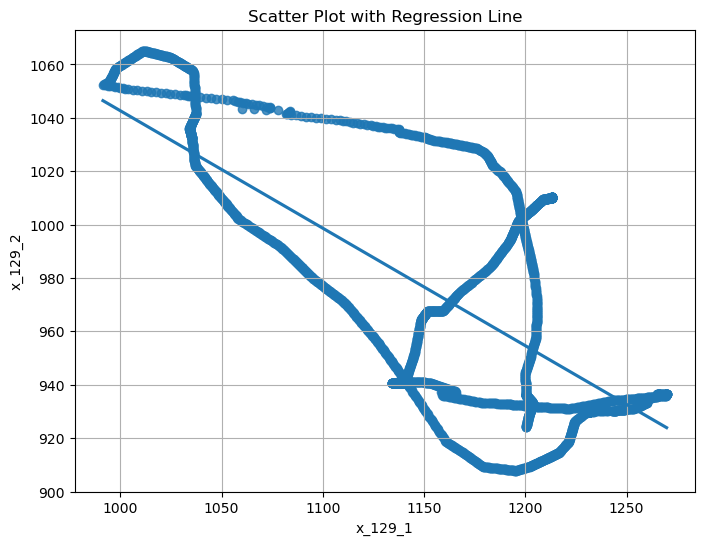

In [63]:
# Scatter Plot with Regression Line
plt.figure(figsize=(8, 6))
sns.regplot(x=x_129_1, y=x_129_2, ci=None)
plt.title('Scatter Plot with Regression Line')
plt.xlabel('x_129_1')
plt.ylabel('x_129_2')
plt.grid(True)
plt.show()

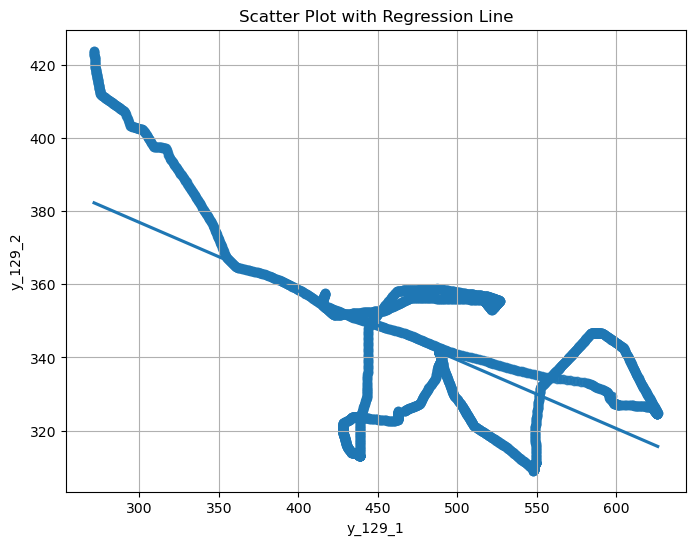

In [64]:
# Scatter Plot with Regression Line
plt.figure(figsize=(8, 6))
sns.regplot(x=y_129_1, y=y_129_2, ci=None)
plt.title('Scatter Plot with Regression Line')
plt.xlabel('y_129_1')
plt.ylabel('y_129_2')
plt.grid(True)
plt.show()

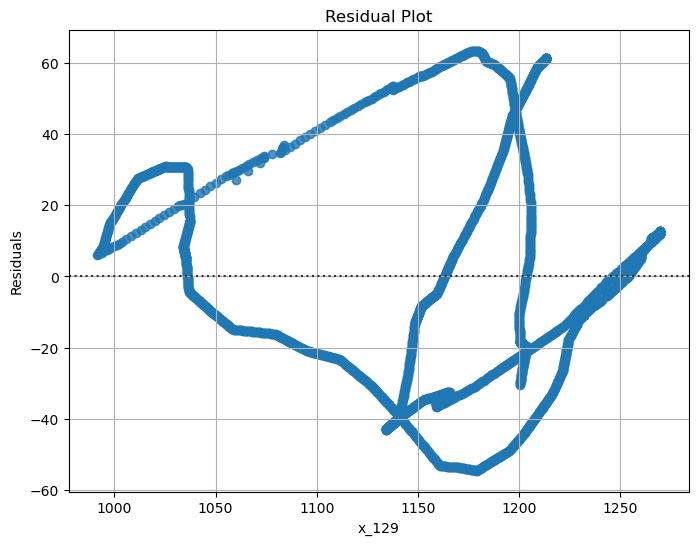

In [66]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=x_129_1, y=x_129_2)
plt.title('Residual Plot')
plt.xlabel('x_129')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

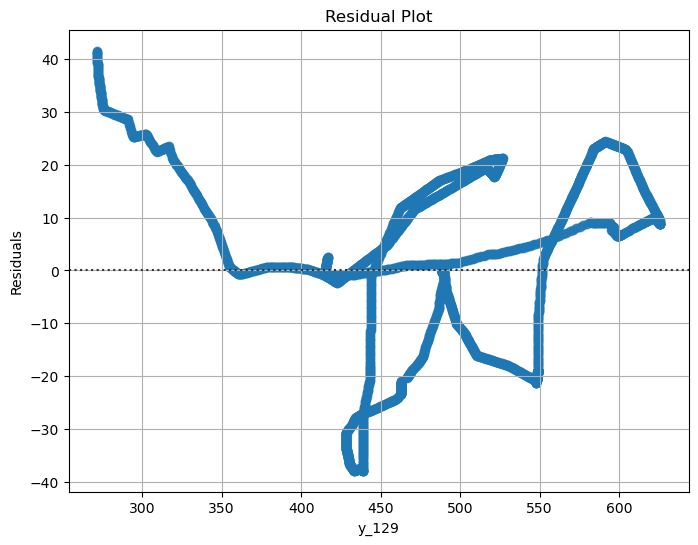

In [67]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=y_129_1, y=y_129_2)
plt.title('Residual Plot')
plt.xlabel('y_129')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

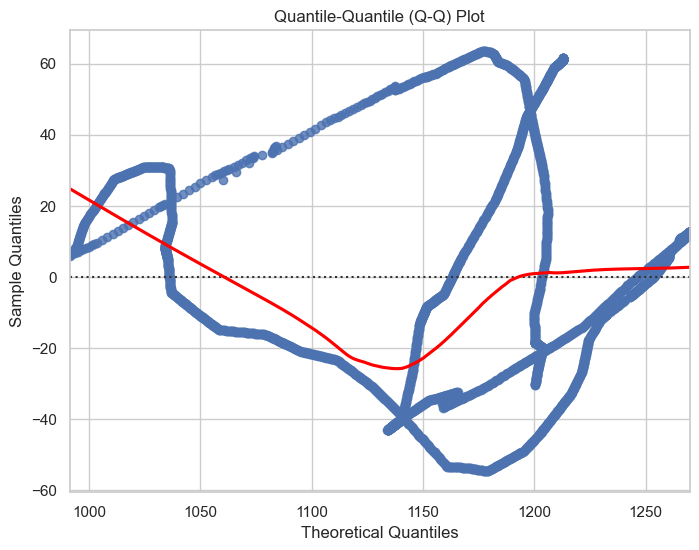

In [68]:
# Quantile-Quantile (Q-Q) Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.residplot(x=x_129_1, y=x_129_2, lowess=True, line_kws={'color': 'red'})
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

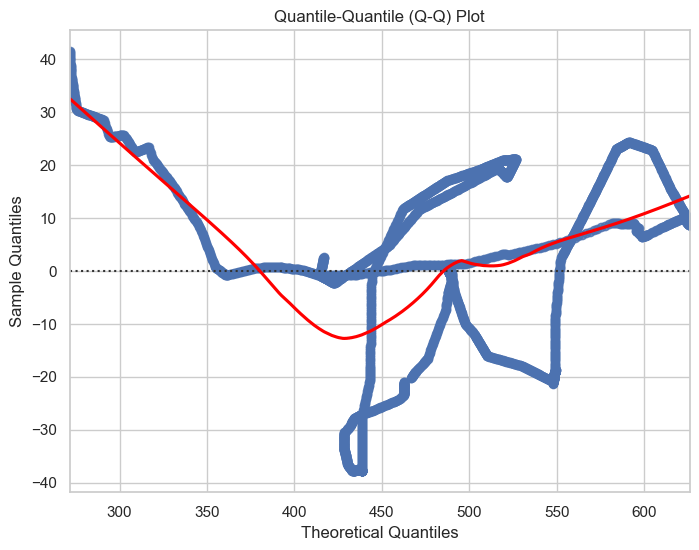

In [69]:
# Quantile-Quantile (Q-Q) Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.residplot(x=y_129_1, y=y_129_2, lowess=True, line_kws={'color': 'red'})
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

## Conclusion

we can conclude that the data in its original form needs to be cleaned up for usage. It is also necessary to make adjustments for video pairs as the number of frames is not always equal. Tracking data is also not always overlapping, some fish will be tracked in a given frame in video 1 but not video 2 and vice versa. This does allow for the prediction of tracking data for a video if the subject is tracked in the other video. The camera data also is extensive. Based on the statistics and graphs predicting the x or y coordinates of a tracked subject in video 1 for video 2 is not possible without using the x and y coordinates alone without taking the camera data into consideration. This also applies for leveraging the two to create a 3d view. The camera data is of high relevance and will be used when creating the algorithm to leverage the video feeds and try to predict tracking data.